# Gaussian Barycenter Computation

In [7]:
from mmot import MMOTSolver

import skimage.filters
import numpy as np 
import matplotlib.pyplot as plt 
import itertools

0.6000000000000001  vs  0.6000000000000001


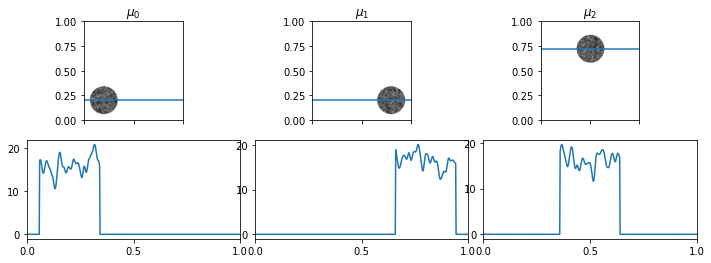

In [8]:
# Grid of size n1 x n2
n1 = 512   # x axis
n2 = 512  # y axis

x1d = np.linspace(0.5/n1,1-0.5/n1,n1)
y1d = np.linspace(0.5/n2,1-0.5/n1,n2)
x, y = np.meshgrid(x1d, y1d)

r = 0.1

spacing = 0.6
x0 = 0.5*(1.0-spacing)
positions = np.array([[x0,x0],
                      [x0+spacing,x0],
                      [x0+0.5*spacing,x0+spacing*np.sin(np.pi/3)]])

print(np.linalg.norm(positions[2]-positions[0]), ' vs ', np.linalg.norm(positions[1]-positions[0]))
true_loc = np.mean(positions,axis=0)

# measures = [None]*len(positions)
measures = [None]*(len(positions))

for i in range(len(positions)):

    xc,yc = positions[i]
    measures[i] = skimage.filters.gaussian(0.5*np.random.randn(n2,n1), sigma=(3, 3), truncate=20)

    support = ((x-xc)**2 + (y-yc)**2) < 0.02
    measures[i][support] += 1.0
    measures[i][~support] = 0.0
    measures[i] *= n1*n2 / np.sum(measures[i])

vmax = np.max([m.max() for m in measures])
true_cost = 0.5/3.0*(np.linalg.norm(true_loc-positions[0])**2 \
          + np.linalg.norm(true_loc-positions[1])**2 \
          + np.linalg.norm(true_loc-positions[2])**2)

fig, ax = plt.subplots(nrows=2, ncols=len(measures), figsize=(12,4),sharex=True)
for i in range(len(measures)):
    ax[0,i].imshow(measures[i], origin='lower', extent=(0,1,0,1),vmin=0, vmax=vmax,cmap='Greys')
    ax[0,i].set_title("$\\mu_{{ {:0d} }}$".format(i))

    xind = np.argmin(np.abs(positions[i][0] - x1d))
    yind = np.argmin(np.abs(positions[i][1] - y1d))
    ax[0,i].plot(x1d,y1d[yind]*np.ones(n1))

    ax[1,i].plot(x1d,measures[i][yind,:])
plt.subplots_adjust(wspace=0.07)
plt.show()

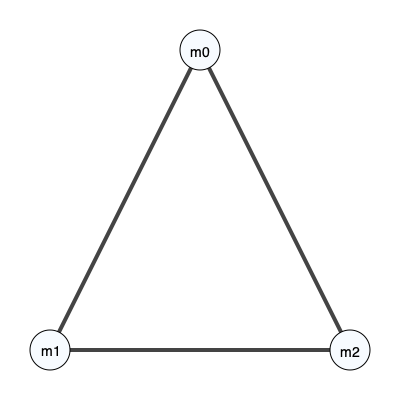

In [9]:
unroll_node = 0

# The set A that defines the pairwise costs
edge_list = [[0,1], [1,2], [0,2]]

bary_weights = np.array([1.0,1.0,1.0])
bary_weights /= np.sum(bary_weights)

prob = MMOTSolver(measures, edge_list, x, y, unroll_node, bary_weights)

prob.Visualize('original', filename='CostGraph.svg')

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  1.2943e-02,   1.2400e+00,         2
       10,   0.0014,  5.9816e-02,   1.7551e-02,         4
       20,   0.0017,  5.9963e-02,   1.1144e-03,         0
       30,   0.0040,  5.9970e-02,   8.4882e-05,         0
       38,   0.0043,  5.9972e-02,   3.6305e-05,         0
Terminating due to small change in objective.


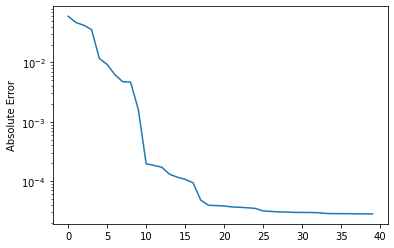

In [10]:
dual_vars = [np.zeros(x.shape) for i in range(prob.NumDual())]

res = prob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-8, gtol_abs=1e-8, root_nodes='all')

plt.figure()
plt.semilogy(np.abs(res.costs-true_cost))
plt.ylabel('Absolute Error')
plt.show()

In [11]:
bary = prob.Barycenter(res.dual_vars)

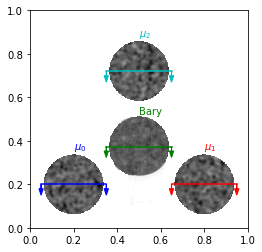

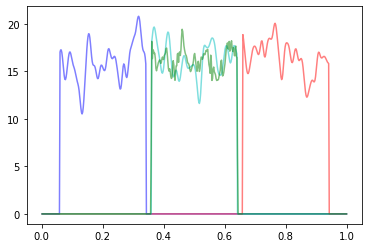

In [12]:
from turtle import position


colors = ['b','r','c','g']

for i in range(len(measures)):
    masked_measure = np.ma.masked_where(measures[i]==0, measures[i])
    plt.imshow(masked_measure,cmap='Greys',origin='lower', extent=(0,1,0,1),vmin=0,vmax=vmax)
    plt.text(positions[i][0], positions[i][1]+0.16,'$\mu_{}$'.format(i), c=colors[i])
    plt.plot([positions[i][0]-0.15, positions[i][0]+0.15], [positions[i][1],positions[i][1]], c=colors[i])
    plt.arrow(positions[i][0]-0.15, positions[i][1], 0, -0.02, color=colors[i],head_width=0.02)
    plt.arrow(positions[i][0]+0.15, positions[i][1], 0, -0.02, color=colors[i],head_width=0.02)

masked_bary = np.ma.masked_where(bary<0.5, bary)
plt.imshow(masked_bary,cmap='Greys',origin='lower', extent=(0,1,0,1),vmin=0,vmax=vmax)
bary_pos = np.mean(positions,axis=0)
plt.text(bary_pos[0], bary_pos[1]+0.15, 'Bary', c=colors[-1])
plt.plot([bary_pos[0]-0.15, bary_pos[0]+0.15], [bary_pos[1],bary_pos[1]], c=colors[-1])
plt.arrow(bary_pos[0]-0.15, bary_pos[1], 0, -0.02, color=colors[-1],head_width=0.02)
plt.arrow(bary_pos[0]+0.15, bary_pos[1], 0, -0.02, color=colors[-1],head_width=0.02)

plt.figure()
for i in range(len(measures)):
    xind = np.argmin(np.abs(positions[i][0] - x1d))
    yind = np.argmin(np.abs(positions[i][1] - y1d))
    plt.plot(x1d,measures[i][yind,:], c=colors[i], alpha=0.5)


xind = np.argmin(np.abs(bary_pos[0] - x1d))
yind = np.argmin(np.abs(bary_pos[1] - y1d))
plt.plot(x1d,bary[yind,:], c=colors[-1], alpha=0.5)


plt.show()